# QLS project: 
# Inferring macro-ecological patterns from local presence/absence data


In [1]:
import numpy as np
import numpy.random as random
from random import sample
import scipy.optimize as optimization
from scipy.stats import nbinom
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import pandas as pd  
import json
from tqdm import tqdm

# LOAD DATA
MxS presence/absence matrix a p*

dflnpa = dataframe, log normal, presence/absence $\to$ LNpa matrix \
dfnbpa = dataframe, negative binomial, presence/absence $\to$ NBpa matrix \
dfpa_bci = dataframe, BCI, presence/absence  $\to$ BCIpa matrix

In [139]:
#whole LN forest
dfln = pd.read_csv(r'dflnpa.csv')
#dfln.set_index(np.arange(1,len(dfln)+1,dtype=int))
LNpa = pd.DataFrame.to_numpy(dfln,dtype=int)

#whole NB forest
dfnb = pd.read_csv(r'dfnbpa.csv')
#dfnb.set_index(np.arange(1,len(dfnb)+1,dtype=int))
NBpa = pd.DataFrame.to_numpy(dfnb,dtype=int)

#whole BCI forest
dfbci = pd.read_csv(r'dfbcipa.csv')
#dfbci.set_index(np.arange(1,len(dfbci)+1,dtype=int))
BCIpa = pd.DataFrame.to_numpy(dfbci,dtype=int)

#whole BIRD dataset
dfbird = pd.read_csv(r'dfbirdpa.csv')
BIRDpa = pd.DataFrame.to_numpy(dfbird)

In [3]:
# 5% in-silico forests
NBpa5 = pd.read_csv(r'NBpa5_file.csv')
NBpa5 = pd.DataFrame.to_numpy(NBpa5,dtype=int)

LNpa5 = pd.read_csv(r'LNpa5_file.csv')
LNpa5 = pd.DataFrame.to_numpy(LNpa5,dtype=int)

# MODEL


#### empSAR
empSAR is calculated for every cell fraction: from the single cell (mean of the rows) to the entire forest considered. At each step this calculation is repeted nr_iter times and then mediated. The result is inserted in empSAR.


In [4]:
# function to compute empSAR and its std

def computeSAR(initial_data,tot_plot,tot_species,nr_iter): 
    
    empSAR = np.zeros(tot_plot)
    sdSAR = np.zeros(tot_plot)

    empSAR[0] = np.mean(np.sum(initial_data,axis=1))        #1st elem is the mean nr of species present in ONE cell

    
    for i in tqdm(range(2,tot_plot+1)):                     

        sar = np.zeros(nr_iter)
        for j in range(nr_iter):
            ind = random.randint(0,tot_plot,i)   
            sample_matrix = initial_data[ind,]
            presentSpecies = np.sum(sample_matrix,axis=0)   #(0 -> column sum)
            sar[j] = len(presentSpecies[presentSpecies != 0])

        empSAR[i-1] = np.mean(sar)                          #the result is a mean over the iterations
        sdSAR[i-1] = np.std(sar)    
        
    return empSAR,sdSAR

#### fit empSAR with thSAR

[python fit](https://stackoverflow.com/questions/43253646/how-to-fit-a-non-linear-function-with-python)

\begin{equation}
\xi_{p} = \frac{p \xi}{1-\xi(1-p)}\\
thSAR = S\frac{1-(1-\xi_p)^r}{1-(1-\xi)^r}\\
\end{equation}

given p, from the fit we obtain an estimation for $\xi_{fit}$ and $r_{fit}$

In [5]:
#functions to evalutate theoretical values/ for the fit

def csip(p,csi):
    return p*csi/(1-csi*(1-p))

def thSAR(p,r,csi,S):
    return S*(1-(1-csip(p,csi))**r)/(1-(1-csi)**r)
    
    
#function to fit the empirical SAC, it returns the optimal fit values, their covariance and the plot

def fitSAR(empSAR,tot_plot,tot_species,plot=True):
    
    #fit
    x = np.arange(1,tot_plot+1)/tot_plot
    y = empSAR
    f = thSAR

    estimated_r = 0.2
    estimated_csi = 0.999
    S = tot_species
    start = [estimated_r,estimated_csi,S]

    popt, pcov = optimization.curve_fit(f, x, y, start)
    
    #std errors on parameters
    perr = []
    for i in range(len(popt)):
        perr.append(np.absolute(pcov[i][i])**0.5)
            
    print('r_fit:',popt[0],'std err:',perr[0])
    print('\ncsi_fit:',popt[1],'std err:',perr[1])

    #plot
    if plot==True:
        plt.plot(x*tot_plot,empSAR,label='empirical',color='navy',marker='.',linestyle='')
        plt.plot(x*tot_plot,thSAR(x,popt[0],popt[1],popt[2]),'c-',label='fit',linewidth=2)
        plt.title('SAC')
        plt.xlabel('nr cell')
        plt.ylabel('S')
        plt.legend()
        plt.show()
    
    return popt, perr

# in-silico forest analysis

We have the entire presence/absence matrix at scale 1, composed by $M=98x98$ cells, $S_{NB}=4981$ and $S_{LN}=5000$ species\
Sample the $p=0.05$ of those matrices\
Infer with the method the $S_{pred}$ at scale 1\
Then compare $S_{NB}$,$S_{LN}$ (known) with $S_{pred,NB}$,$S_{pred,LN}$ inferred with eq 8



#### application to NB 5%

In [6]:
initial_data = NBpa5

tot_plot = initial_data.shape[0]
print("Total number of subplots:",tot_plot)

tot_species = np.sum(initial_data,axis=0)
tot_species = len(tot_species[tot_species!=0])
print("Total number of found species:",tot_species)   #only present species

Total number of subplots: 480
Total number of found species: 4761


In [7]:
nr_iter = 100
empSAR_NB, sdSAR_NB = computeSAR(initial_data,tot_plot,tot_species,nr_iter)

100%|████████████████████████████████████████████████████████████████████████████████| 479/479 [09:25<00:00,  1.18s/it]


In [8]:
poptNB, perrNB = fitSAR(empSAR_NB,tot_plot,tot_species,plot=False)

r_fit: 0.8541574258591531 std err: 0.00160641462495519

csi_fit: 0.9789345991012183 std err: 5.900451029358607e-05


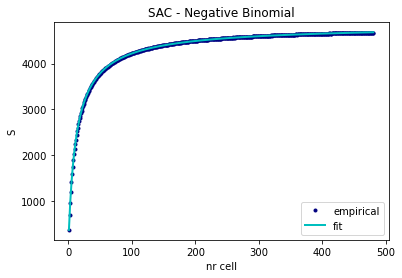

In [9]:
x = np.arange(1,tot_plot+1)/tot_plot
plt.plot(x*tot_plot,empSAR_NB,label='empirical',color='navy',marker='.',linestyle='')
plt.plot(x*tot_plot,thSAR(x,poptNB[0],poptNB[1],poptNB[2]),'c-',label='fit',linewidth=2)
plt.title('SAC - Negative Binomial')
plt.xlabel('nr cell')
plt.ylabel('S')
plt.legend()
plt.savefig('images/SACNB.png')
plt.show()

#### application to LN 5%

In [10]:
initial_data = LNpa5

tot_plot = initial_data.shape[0]
print("Total number of subplots:",tot_plot)

tot_species = np.sum(initial_data,axis=0)
tot_species = len(tot_species[tot_species!=0])
print("Total number of found species:",tot_species)   #only present species

Total number of subplots: 480
Total number of found species: 4817


In [11]:
nr_iter = 100
empSAR_LN, sdSAR_LN = computeSAR(initial_data,tot_plot,tot_species,nr_iter)

100%|████████████████████████████████████████████████████████████████████████████████| 479/479 [08:48<00:00,  1.10s/it]


In [12]:
poptLN, perrLN = fitSAR(empSAR_LN,tot_plot,tot_species,plot=False)

r_fit: 1.0271074058277003 std err: 0.005364270008561814

csi_fit: 0.9158022105801884 std err: 0.00047118341637659116


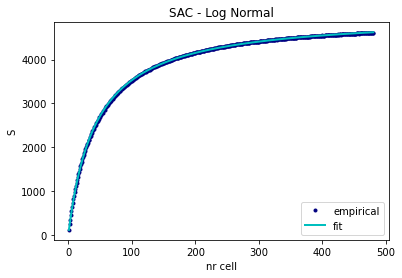

In [13]:
x = np.arange(1,tot_plot+1)/tot_plot
plt.plot(x*tot_plot,empSAR_LN,label='empirical',color='navy',marker='.',linestyle='')
plt.plot(x*tot_plot,thSAR(x,poptLN[0],poptLN[1],poptLN[2]),'c-',label='fit',linewidth=2)
plt.title('SAC - Log Normal')
plt.xlabel('nr cell')
plt.ylabel('S')
plt.legend(loc='lower right')
plt.savefig('images/SACLN.png')
plt.show()

#### infer $S_{est}$ for the entire scale from fit parameters

\begin{equation}
\xi = \frac{\xi_{p^*}}{ p^*+\xi_{p^*} (1-p^*)} \\
S_{est} = S^* \frac{1-(1-\xi)^r}{1-(1-\xi_p^*)^r} \\
err_{S_{est}} = \sqrt{(\frac{dS_{est}}{d\xi_{fit}}std_{\xi_{fit}})^2+(\frac{dS_{est}}{dr_{fit}}std_{r_{fit}})^2}
\end{equation}


In [14]:
# fit results NB 5%
r_fit_NB5 = np.abs(poptNB[0])
csi_fit_NB5 = poptNB[1]
S_NB = 4981          #true value of S at scale 1

# fit results LN 5%
r_fit_LN5 = np.abs(poptLN[0])
csi_fit_LN5 = poptLN[1]
S_LN = 5000          #true value of S at scale 1

In [15]:
#equation 4 to go from fit to global
def csi_global(csi_fit,p):
    return csi_fit/(p+csi_fit*(1-p))

#equation 8 to estimate S for the whole forest
def Sestimated(tot_species,csi_fit,r_fit,p):
    return tot_species*(1-(1-csi_global(csi_fit,p))**r_fit)/(1-(1-csi_fit)**r_fit)

In [16]:
#to derive the error on Sestimated

def N(csi_fit,r_fit,p):
    return 1-(1-csi_fit/(p+csi_fit*(1-p)))**r_fit

def D(csi_fit,r_fit):
    return 1-(1-csi_fit)**r_fit

def dNdc(csi_fit,r_fit,p):
    return (p*r_fit/(p+csi_fit*(1-p))**2)*(1-csi_fit/(p+csi_fit*(1-p)))**(r_fit-1)

def dNdr(csi_fit,r_fit,p):
    return -np.log(1-csi_fit/(p+csi_fit*(1-p)))*(1-csi_fit/(p+csi_fit*(1-p)))**r_fit

def dDdc(csi_fit,r_fit):
    return r_fit*(1-csi_fit)**(r_fit-1)

def dDdr(csi_fit,r_fit):
    return -np.log(1-csi_fit)*(1-csi_fit)**r_fit

def dSdc(csi_fit,r_fit,p,tot_species):
    return tot_species*(dNdc(csi_fit,r_fit,p)*D(csi_fit,r_fit)-dDdc(csi_fit,r_fit)*N(csi_fit,r_fit,p))/D(csi_fit,r_fit)**2

def dSdr(csi_fit,r_fit,p,tot_species):
    return tot_species*(dNdr(csi_fit,r_fit,p)*D(csi_fit,r_fit)-dDdr(csi_fit,r_fit)*N(csi_fit,r_fit,p))/D(csi_fit,r_fit)**2

def errSestimated(csi_fit,r_fit,p,tot_species,perr):
    return np.sqrt((dSdc(csi_fit,r_fit,p,tot_species)*perr[1])**2+(dSdr(csi_fit,r_fit,p,tot_species)*perr[0])**2)

In [17]:
#upscaling from p=0.05 to 1
p = 0.05     #sampled_area/area

#NB5 upscaling
tot_speciesNB5 = np.sum(NBpa5,axis=0)
tot_speciesNB5 = len(tot_speciesNB5[tot_speciesNB5!=0])

csi_global_NB = csi_global(csi_fit_NB5,p)
S_estimate_NB = Sestimated(tot_speciesNB5,csi_fit_NB5,r_fit_NB5,p)
errS_estimate_NB = errSestimated(csi_fit_NB5,r_fit_NB5,p,tot_speciesNB5,perrNB)
print('NB results:')
print('csi_global:',csi_global_NB,'Sest:',np.round(S_estimate_NB),'errSest:',np.round(errS_estimate_NB))

#LN5 upscaling
tot_speciesLN5 = np.sum(LNpa5,axis=0)
tot_speciesLN5 = len(tot_speciesLN5[tot_speciesLN5!=0]) 

csi_global_LN = csi_global(csi_fit_LN5,p)
S_estimate_LN = Sestimated(tot_speciesLN5,csi_fit_LN5,r_fit_LN5,p)
errS_estimate_LN = errSestimated(csi_fit_LN5,r_fit_LN5,p,tot_speciesLN5,perrLN)
print('LN results:')
print('csi_global:',csi_global_LN,'Sest:',np.round(S_estimate_LN),'errSest:',np.round(errS_estimate_LN))

NB results:
csi_global: 0.9989252213439573 Sest: 4929.0 errSest: 1.0
LN results:
csi_global: 0.9954240933670804 Sest: 5208.0 errSest: 6.0


In [18]:
"""#NB
probNB_pred = nbinom.pmf(x, r_fit_NB5, 1-csi_global_NB)
probNB_real = nbinom.pmf(x, 0.8, 1-0.999)

plt.plot(probNB_pred,'b--',label='NB prediction')
plt.plot(probNB_real,label='real NB distribution')
plt.title('NB RSA')
plt.xlabel('number of individuals')
plt.ylabel('number of species')
#plt.xscale('log')
plt.legend()
plt.show()

#LN
probLN_pred = nbinom.pmf(x, r_fit_LN5, 1-csi_global_LN)
probLN_real = lognorm.pdf(x, 5, 1)

plt.plot(probLN_pred,'b--',label='NB prediction')
plt.plot(probLN_real,label='real LN distribution')
plt.title('LN RSA')
plt.xlabel('number of individuals')
plt.ylabel('number of species')
#plt.xscale('log')
plt.legend()
plt.show()"""

"#NB\nprobNB_pred = nbinom.pmf(x, r_fit_NB5, 1-csi_global_NB)\nprobNB_real = nbinom.pmf(x, 0.8, 1-0.999)\n\nplt.plot(probNB_pred,'b--',label='NB prediction')\nplt.plot(probNB_real,label='real NB distribution')\nplt.title('NB RSA')\nplt.xlabel('number of individuals')\nplt.ylabel('number of species')\n#plt.xscale('log')\nplt.legend()\nplt.show()\n\n#LN\nprobLN_pred = nbinom.pmf(x, r_fit_LN5, 1-csi_global_LN)\nprobLN_real = lognorm.pdf(x, 5, 1)\n\nplt.plot(probLN_pred,'b--',label='NB prediction')\nplt.plot(probLN_real,label='real LN distribution')\nplt.title('LN RSA')\nplt.xlabel('number of individuals')\nplt.ylabel('number of species')\n#plt.xscale('log')\nplt.legend()\nplt.show()"

Average relative error (%)

\begin{equation}
AvgPercErr = \frac{S_{est}-S_{real}}{S_{real}}100 = (\frac{S_{est}}{S_{real}}-1)100 \\
err.formula = \frac{100}{S_{real}}std_{S_{est}}
\end{equation}



In [19]:
#average relative percentage error (table1 p7)
def av_perc_err(Spred,errSpred,S):
    av = ((Spred-S)/S)*100
    std = 100*errSpred/S   
    return av,std

In [20]:
percerrNB = av_perc_err(S_estimate_NB,errS_estimate_NB,S_NB)
percerrLN = av_perc_err(S_estimate_LN,errS_estimate_LN,S_LN) 
print('% err NB:',np.round(percerrNB[0],2),'+-',np.round(percerrNB[1],2))
print('% err LN:',np.round(percerrLN[0]),'+-',np.round(percerrLN[1],1))

% err NB: -1.03 +- 0.02
% err LN: 4.0 +- 0.1


# real datasets analysis

We have the entire presence/absence matrix at scale p* with S* species\
Sample $p=0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9$ of those matrices\
And for each subsample infer, through the method, the $S_{est}$ at the entire scale p*\
Then plot each of these $S_{est}$ with a plot similar to Figure2\
To compare $S_{est}$ and $S^*$ calculate $rel_{err} = \frac{S_{est} - S^*}{S^*}100$

In [21]:
#function to take submatrices with a fraction f of the entire cells
#they're stored in a list, which is returned

def subsampled_mat(entire_matrix):
    # total nr of cells
    tot_plot = entire_matrix.shape[0]
    #p = np.linspace(0.1,0.9,9)
    p = np.linspace(0.1,1,10)         #it predicts also the scale 1
    frac = p*tot_plot

    list_of_mat = []
    for f in frac:
        #sample f indices 
        ind = random.choice(np.arange(0,tot_plot),size=int(f),replace=False) 
        #take the submatrix with those indices
        reduced_matrix = entire_matrix[ind,]
        list_of_mat.append(reduced_matrix)
    return list_of_mat

In [22]:
#ALTERNATIVE: sample, at each iteration, the 0.1 of the matrix and keep fixed the previous matrix 

def subsampled_mat1(entire_matrix):
    # total nr of cells
    tot_plot = entire_matrix.shape[0]
    p = 0.1
    frac = p*tot_plot  #corresponds to the 1% of the cells

    list_of_mat = []
    #for i in range(1,tot_plot):
    for i in range(1,tot_plot):
        ind_list = [j for j in range(int(frac)*i)]   
        if len(ind_list)>tot_plot:
            break
        #take the submatrix with those indices
        reduced_matrix = entire_matrix[ind_list,]
        #append it
        list_of_mat.append(reduced_matrix)
    return list_of_mat

#### Chao_wor estimator 
\begin{equation}
S_{chao} = S^* + \frac{Q_1^2}{\frac{2Q_2M^*}{M^*-1}+\frac{Q_1 p^*}{1-p^*}}
\end{equation}

$M^*$= total nr of sampled cells, $S^*$= total nr of found species, $Q_i$= nr of species detected in i plot at scale $p^*$

In [23]:
def Schao(empSAR,tot_plot,p):
    Q1 = empSAR[0]
    Q2 = empSAR[1]
    Mstar = tot_plot
    Sstar = empSAR[-1]
    pstar = p
    return Sstar+Q1**2/(2*Q2*(Mstar/(Mstar-1))+Q1*(pstar/(1-pstar)))

In [24]:
#function that automatize the the three process:
#empSAR,fit and upscaling estimation of S
def empfitup(initial_data,nr_iter,p):

    tot_plot = initial_data.shape[0]
    
    tot_species = np.sum(initial_data,axis=0)
    tot_species = len(tot_species[tot_species!=0])  
    
    empSAR, sdSAR = computeSAR(initial_data,tot_plot,tot_species,nr_iter)
    popt, perr = fitSAR(empSAR,tot_plot,tot_species)
    
    #print("Total number of subplots:",tot_plot)
    #print("Total number of found species:",tot_species)   #only present species

    return Sestimated(tot_species,popt[1],popt[0],p),errSestimated(popt[1],popt[0],p,tot_species,perr),Schao(empSAR,tot_plot,p)      #csi_fit,r_fit,p

### application to BCI

In [178]:
np.random.shuffle(BCIpa)
subsampled_matBCI = subsampled_mat(BCIpa)

 14%|███████████▎                                                                     | 11/79 [00:00<00:00, 109.36it/s]

302


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.48it/s]


r_fit: 0.3618871596664235 std err: 0.010615466222002103

csi_fit: 0.9868178021768351 std err: 0.0004855557865144646


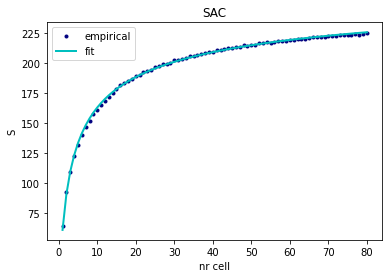

100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [00:04<00:00, 38.12it/s]


r_fit: 0.35850801690412887 std err: 0.0052324876327533

csi_fit: 0.9931558944961121 std err: 0.0001502643581477575


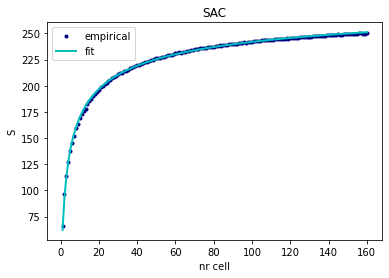

100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [00:07<00:00, 30.80it/s]


r_fit: 0.3117314221737433 std err: 0.0026874498826974093

csi_fit: 0.9957306418574455 std err: 5.8778778529221815e-05


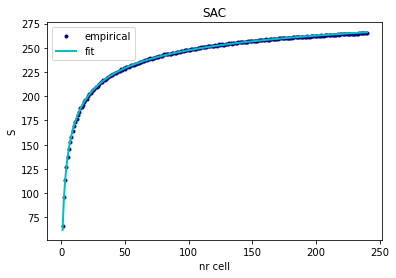

100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:11<00:00, 27.36it/s]


r_fit: 0.3524883475757389 std err: 0.0028178133318368043

csi_fit: 0.9961820415374717 std err: 5.310568268937802e-05


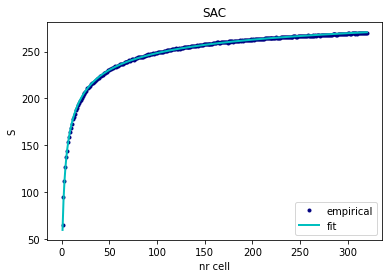

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [00:19<00:00, 20.26it/s]


r_fit: 0.2609688652616097 std err: 0.001115365439680814

csi_fit: 0.9978006028763752 std err: 1.634741605122671e-05


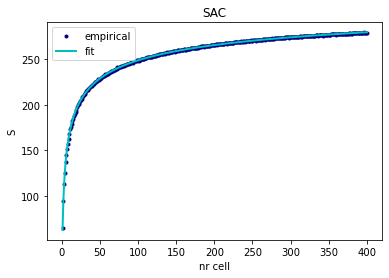

100%|████████████████████████████████████████████████████████████████████████████████| 479/479 [00:25<00:00, 18.59it/s]


r_fit: 0.2999179293055508 std err: 0.0014671740799943162

csi_fit: 0.9978580737655633 std err: 1.9647803370975264e-05


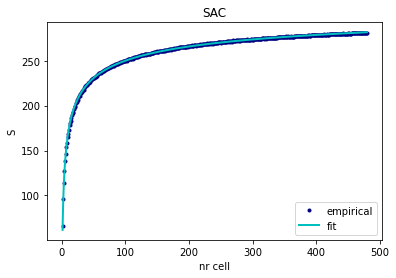

100%|████████████████████████████████████████████████████████████████████████████████| 559/559 [00:32<00:00, 17.29it/s]


r_fit: 0.266252745654636 std err: 0.0010088171672216519

csi_fit: 0.9983863928197428 std err: 1.1631619719171522e-05


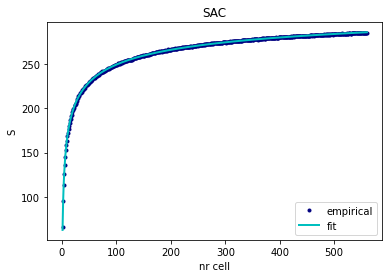

100%|████████████████████████████████████████████████████████████████████████████████| 639/639 [00:41<00:00, 15.39it/s]


r_fit: 0.29121678704327736 std err: 0.0009460457850715148

csi_fit: 0.9984319664185676 std err: 1.018435793552116e-05


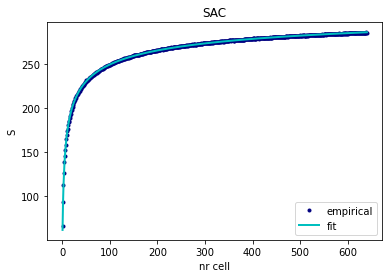

100%|████████████████████████████████████████████████████████████████████████████████| 719/719 [00:48<00:00, 14.83it/s]


r_fit: 0.2653690261292985 std err: 0.0008329148367565115

csi_fit: 0.9987275741510532 std err: 8.048746502840398e-06


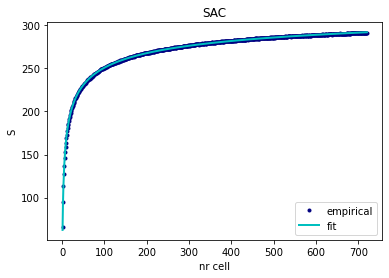

100%|████████████████████████████████████████████████████████████████████████████████| 799/799 [00:57<00:00, 13.93it/s]


r_fit: 0.2721486563617334 std err: 0.0007950995291475571

csi_fit: 0.9988222903882211 std err: 7.15196287726782e-06


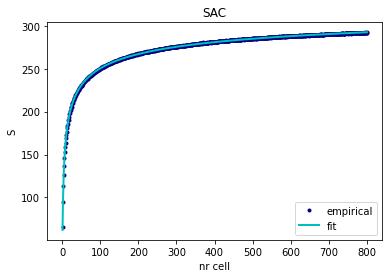

<ipython-input-23-6c2c8bb80432>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return Sstar+Q1**2/(2*Q2*(Mstar/(Mstar-1))+Q1*(pstar/(1-pstar)))


In [179]:
#p = np.linspace(0.1,0.9,9)
p = np.linspace(0.1,1,10)

#true S    
S_trueBCI = np.sum(BCIpa,axis=0)
S_trueBCI = len(S_trueBCI[S_trueBCI!=0])
print(S_trueBCI)

#list of estimated S
S_BCI = []
Serr_BCI = []
Schao_BCI = []
#for i in range(9):
for i in range(10):
    subm = subsampled_matBCI[i]
    func = empfitup(subm,200,p[i])
    S_BCI.append(func[0])
    Serr_BCI.append(func[1])
    Schao_BCI.append(func[2])
    


In [180]:
#errors in the estimation
av_perc_err_BCI = av_perc_err(np.array(S_BCI),np.array(Serr_BCI),S_trueBCI)

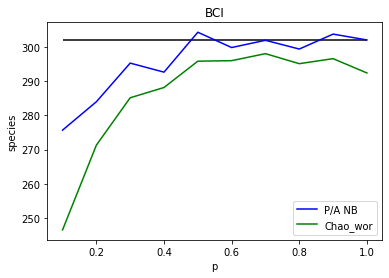

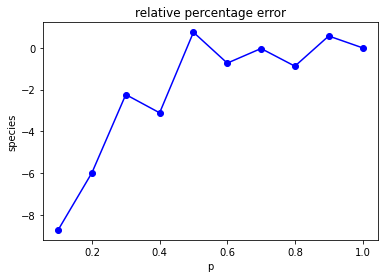

In [181]:
plt.plot(p,S_BCI,'b',label='P/A NB')
plt.plot(p,Schao_BCI,'g',label='Chao_wor')
plt.hlines(S_trueBCI,xmin=0.1,xmax=1,label=r'$S_{real}$')
plt.title('BCI')
plt.xlabel('p')
plt.ylabel('species')
plt.legend(loc='lower right')
plt.savefig('images/BCIestimation.png')
plt.show()

plt.plot(p,av_perc_err_BCI[0],'b-o')
plt.title('relative percentage error')
plt.xlabel('p')
plt.ylabel('species')
plt.savefig('images/BCIerr.png')
plt.show()

### application to BIRD

In [182]:
np.random.shuffle(BIRDpa)
subsampled_matBIRD = subsampled_mat(BIRDpa)

  7%|█████▍                                                                            | 7/105 [00:00<00:01, 65.52it/s]

246


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:02<00:00, 44.53it/s]


r_fit: 0.12234694385625253 std err: 0.009629827763523556

csi_fit: 0.9935655935730703 std err: 0.0003839040003617938


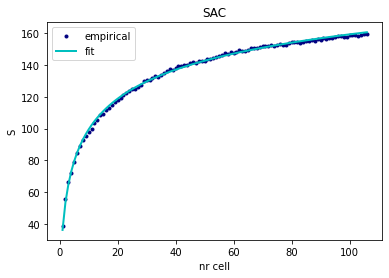

100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:06<00:00, 32.63it/s]


r_fit: 0.0815404224279441 std err: 0.004693869240547358

csi_fit: 0.9972085250947946 std err: 0.00011407083763721875


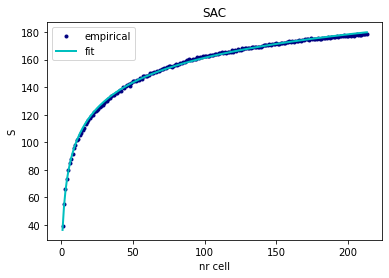

100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:13<00:00, 24.23it/s]


r_fit: 0.039153391404646916 std err: 0.002603453546604881

csi_fit: 0.99843603508928 std err: 4.6281307937729074e-05


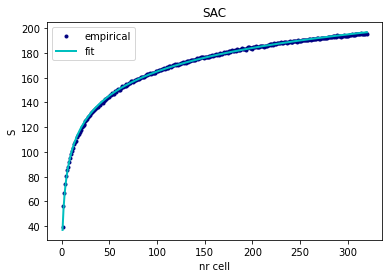

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [00:20<00:00, 20.26it/s]


r_fit: 0.11675974029521169 std err: 0.0035919163511609307

csi_fit: 0.9980121319320631 std err: 6.425392723271629e-05


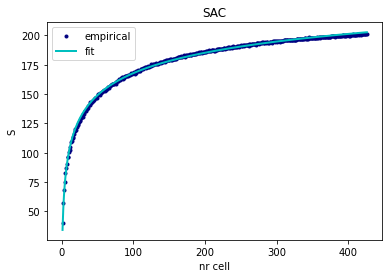

100%|████████████████████████████████████████████████████████████████████████████████| 532/532 [00:31<00:00, 16.84it/s]


r_fit: 0.10114567158010769 std err: 0.002974880004110496

csi_fit: 0.9983576577745651 std err: 4.799003273234321e-05


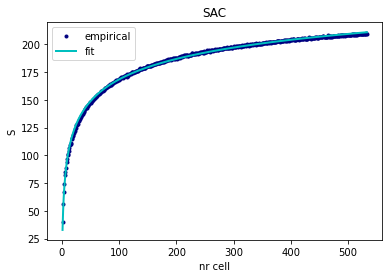

100%|████████████████████████████████████████████████████████████████████████████████| 639/639 [00:58<00:00, 10.85it/s]


r_fit: 0.10114579692337676 std err: 0.00230134589350149

csi_fit: 0.9987854883424532 std err: 2.9974485956397994e-05


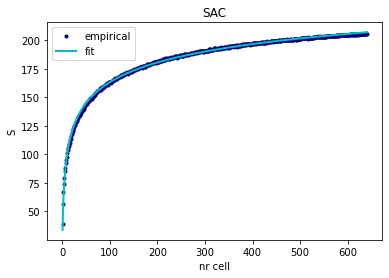

100%|████████████████████████████████████████████████████████████████████████████████| 745/745 [01:31<00:00,  8.12it/s]


r_fit: 0.09880757021270276 std err: 0.0021464831807826664

csi_fit: 0.9987544723311123 std err: 2.8597573326877494e-05


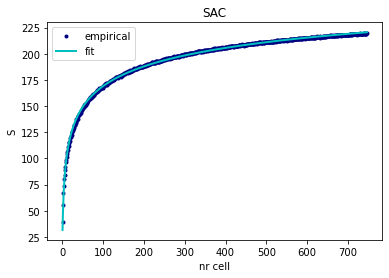

100%|████████████████████████████████████████████████████████████████████████████████| 852/852 [02:03<00:00,  6.88it/s]


r_fit: 0.08121135995997664 std err: 0.00179988886035036

csi_fit: 0.9990096841928634 std err: 2.1155586620102713e-05


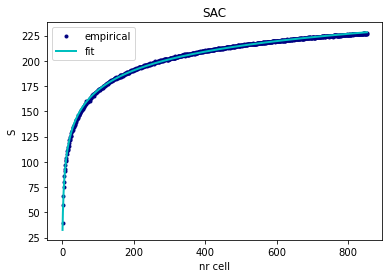

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [02:45<00:00,  5.80it/s]


r_fit: 0.08170103756668308 std err: 0.001414614584209022

csi_fit: 0.9991198739834858 std err: 1.5265403709047573e-05


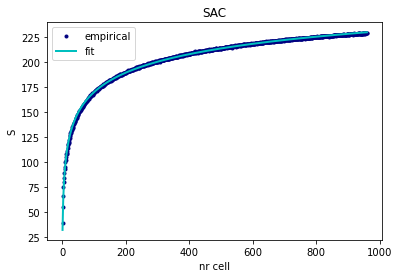

100%|██████████████████████████████████████████████████████████████████████████████| 1066/1066 [03:42<00:00,  4.80it/s]


r_fit: 0.08630179712425173 std err: 0.001462572753694272

csi_fit: 0.999163576422456 std err: 1.5058945202408437e-05


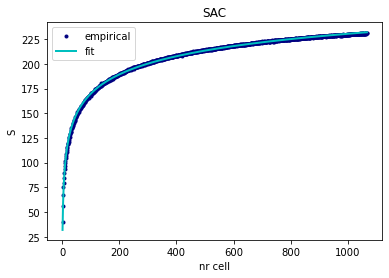

<ipython-input-23-6c2c8bb80432>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return Sstar+Q1**2/(2*Q2*(Mstar/(Mstar-1))+Q1*(pstar/(1-pstar)))


In [183]:
#p = np.linspace(0.1,0.9,9)
p = np.linspace(0.1,1,10)

#true S   
S_trueBIRD = np.sum(BIRDpa,axis=0)
S_trueBIRD = len(S_trueBIRD[S_trueBIRD!=0])
print(S_trueBIRD)

#list of estimated S
S_BIRD = []
Serr_BIRD = []
Schao_BIRD = []
#for i in range(9):
for i in range(10):
    subm = subsampled_matBIRD[i]
    func = empfitup(subm,200,p[i])
    S_BIRD.append(func[0])
    Serr_BIRD.append(func[1])
    Schao_BIRD.append(func[2])


In [184]:
#errors in the estimation
av_perc_err_BIRD = av_perc_err(np.array(S_BIRD),np.array(Serr_BIRD),S_trueBIRD)

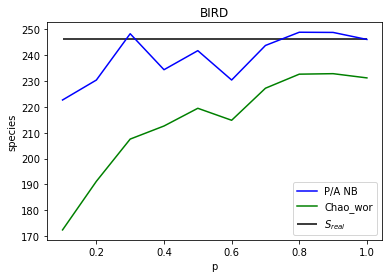

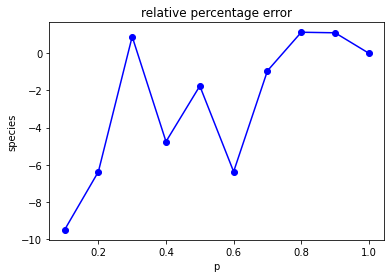

In [198]:
#p = np.linspace(0.1,0.9,9)
p = np.linspace(0.1,1,10)

plt.plot(p,S_BIRD,'b',label='P/A NB')
plt.plot(p,Schao_BIRD,'g',label='Chao_wor')
plt.hlines(S_trueBIRD,xmin=0.1,xmax=1,label=r'$S_{real}$')
plt.title('BIRD')
plt.xlabel('p')
plt.ylabel('species')
plt.legend(loc='lower right')
plt.savefig('images/BIRDestimation.png')
plt.show()

plt.plot(p,av_perc_err_BIRD[0],'b-o')
plt.title('relative percentage error')
plt.xlabel('p')
plt.ylabel('species')
plt.savefig('images/BIRDerr')
plt.show()

## p = 0.1 - Figure 3

We subsample only $p=0.1$ of the whole forest $\to$ we take form the subsampled_mat the first element, which corresponds to this p
- FIG1: empirical SAC plot
- FIG2: cumulative empirical RSA = distribution of abundances across species against the framework prediction in log scale 
- FIG3/FIG4: empirical RSO = distribution of the occurrences (nr of occupied cells) across species in logarithmic scale. FIG3 is cumulative ???


Once the parameters at scale p* are obtained: $r$, $\xi_{p^*}$ (r from the fit, $\xi$ from the fit)\
we can compute the parameters at the whole scale: $r$, $\xi_{p^*}$ (r is the same, $\xi$ from the globalXi function)

#### empirical SAC

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 102.30it/s]


r_fit: 0.37102180883297037 std err: 0.010267184167062217

csi_fit: 0.9865375063747746 std err: 0.0004708982120371008


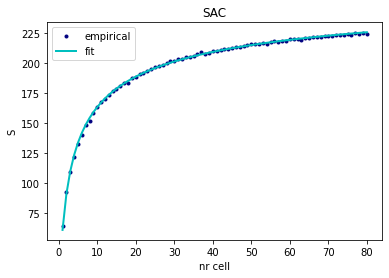

  1%|█                                                                               | 11/799 [00:00<00:07, 108.70it/s]

csi_global= 0.9986372390934621 r= 0.37102180883297037
S_est= 275.0 errS_est 1.0
S_real= 302


100%|████████████████████████████████████████████████████████████████████████████████| 799/799 [01:02<00:00, 12.76it/s]


In [186]:
#BCI
initial_data = subsampled_matBCI[0]
tot_plot = initial_data.shape[0]
#print("Total number of subplots:",tot_plot)
tot_species = np.sum(initial_data,axis=0)
tot_species = len(tot_species[tot_species!=0])
#print("Total number of found species:",tot_species)   #only present species

#fit
nr_iter = 100
empSAR_BCI01, sdSAR_BCI01 = computeSAR(initial_data,tot_plot,tot_species,nr_iter)
poptBCI01, perrBCI01 = fitSAR(empSAR_BCI01,tot_plot,tot_species,plot=False)

#upscaling
p = 0.1
csi_global_BCI = csi_global(poptBCI01[1],p)
S_estimate_BCI = Sestimated(tot_species,poptBCI01[1],poptBCI01[0],p)
errS_estimate_BCI = errSestimated(poptBCI01[1],poptBCI01[0],p,tot_species,perrBCI01)
print('csi_global=',csi_global_BCI,'r=',poptBCI01[0])
print('S_est=',np.round(S_estimate_BCI),'errS_est',np.round(errS_estimate_BCI))
print('S_real=',S_trueBCI)

#empirical SAC using the whole matrix
initial_data = BCIpa
tot_plot = initial_data.shape[0]
tot_species = np.sum(initial_data,axis=0)
tot_species = len(tot_species[tot_species!=0])
#fit
nr_iter = 100
empSAR_BCI, sdSAR_BCI = computeSAR(initial_data,tot_plot,tot_species,nr_iter)

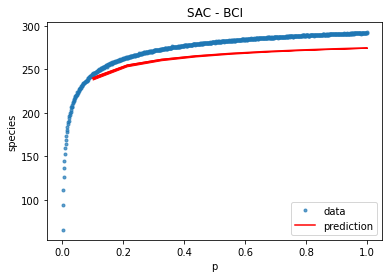

In [187]:
#SAC - BCI 
p = np.linspace(0.1,1,9)
x = np.arange(1,tot_plot+1)/tot_plot
y = thSAR(p,poptBCI01[0],csi_global_BCI,S_estimate_BCI)
ci = errSestimated(poptBCI01[1],poptBCI01[0],p,S_estimate_BCI,perrBCI01)

plt.plot(x,empSAR_BCI,'.',label='data',alpha=0.7)
plt.plot(p,y,'r',label='prediction')
plt.fill_between(p, (y-ci), (y+ci), color='r')
plt.title('SAC - BCI')
plt.xlabel('p')
plt.ylabel('species')
plt.legend(loc='lower right')
plt.savefig('images/SACBCI.png')
plt.show()

In [188]:
#BIRD
initial_data = subsampled_matBIRD[0]
tot_plot = initial_data.shape[0]
#print("Total number of subplots:",tot_plot)
tot_species = np.sum(initial_data,axis=0)
tot_species = len(tot_species[tot_species!=0])
#print("Total number of found species:",tot_species)   #only present species

#fit
nr_iter = 100
empSAR_BIRD01, sdSAR_BIRD01 = computeSAR(initial_data,tot_plot,tot_species,nr_iter)
poptBIRD01, perrBIRD01 = fitSAR(empSAR_BIRD01,tot_plot,tot_species,plot=False)

#upscaling
p = 0.1
csi_global_BIRD = csi_global(poptBIRD01[1],p)
S_estimate_BIRD = Sestimated(tot_species,poptBIRD01[1],poptBIRD01[0],p)
errS_estimate_BIRD = errSestimated(poptBIRD01[1],poptBIRD01[0],p,tot_species,perrBIRD01)
print('csi_global=',csi_global_BIRD,'r=',poptBIRD01[0])
print('S_est=',np.round(S_estimate_BIRD),'errS_est',np.round(errS_estimate_BIRD))
print('S_real=',S_trueBIRD)

#empirical SAC using the whole matrix
initial_data = BIRDpa
tot_plot = initial_data.shape[0]
tot_species = np.sum(initial_data,axis=0)
tot_species = len(tot_species[tot_species!=0])
#fit
nr_iter = 100
empSAR_BIRD, sdSAR_BIRD = computeSAR(initial_data,tot_plot,tot_species,nr_iter)

  1%|█                                                                              | 14/1066 [00:00<00:08, 124.05it/s]

r_fit: 0.11087887339397587 std err: 0.009816544221643745

csi_fit: 0.9939628753159987 std err: 0.0003823883352672611
csi_global= 0.9993929893927515 r= 0.11087887339397587
S_est= 224.0 errS_est 2.0
S_real= 246


100%|██████████████████████████████████████████████████████████████████████████████| 1066/1066 [02:32<00:00,  6.99it/s]


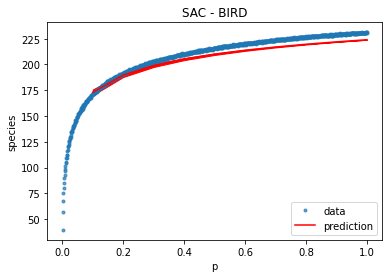

In [189]:
#SAC - BIRD
p = np.linspace(0.1,1,10)
x = np.arange(1,tot_plot+1)/tot_plot
y = thSAR(p,poptBIRD01[0],csi_global_BIRD,S_estimate_BIRD)
ci = errSestimated(poptBIRD01[1],poptBIRD01[0],p,S_estimate_BIRD,perrBIRD01)

plt.fill_between(p, (y-ci), (y+ci), color='r')
plt.plot(x,empSAR_BIRD,'.',label='data',alpha=0.7)
plt.plot(p,y,'r',label='prediction')
plt.title('SAC - BIRD')
plt.xlabel('p')
plt.ylabel('species')
plt.legend(loc='lower right')
plt.savefig('images/SACBIRD.png')
plt.show()

#### cumulative RSA

cumulative RSA of the NB$(r,1-\xi_{global})$, it has to be compared with the real RSA

In [190]:
#factor c that has to be multiplied by the NB(csi,r) to have the RSA
def factorc(csi,r):
    return 1/(1-(1-csi)**r)

In [191]:
RSABCI = pd.read_csv(r'cumRSABCI.csv')
RSABIRD = pd.read_csv(r'cumRSABIRD.csv')

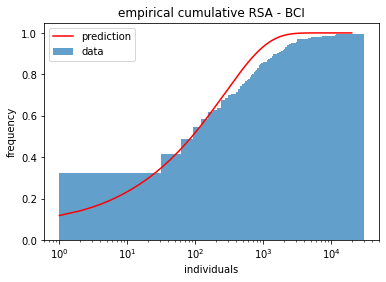

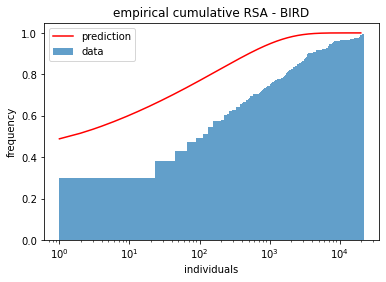

In [192]:
x = np.arange(1,20000)

#BCI
#probBCI = factorc(csi_global_BCI,poptBCI01[0])*nbinom.pmf(x, poptBCI01[0], 1-csi_global_BCI)
probBCI = nbinom.cdf(x, poptBCI01[0], 1-csi_global_BCI)

plt.hist(RSABCI['sp'].value_counts(),bins=1000,density=True,label='data',alpha=0.7,cumulative=True)
plt.plot(x,probBCI,'r',label='prediction')
plt.title('empirical cumulative RSA - BCI')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('individuals')
plt.ylabel('frequency')
plt.legend()
plt.savefig('images/cumRSABCI.png')
plt.show()

#BIRD
#probBIRD = factorc(csi_global_BIRD,poptBIRD01[0])*nbinom.pmf(x, poptBIRD01[0], 1-csi_global_BIRD)
probBIRD = nbinom.cdf(x, poptBIRD01[0], 1-csi_global_BIRD)

plt.hist(RSABIRD.sum(axis=0)[2:],bins=1000,density=True,label='data',alpha=0.7,cumulative=True)
plt.plot(x,probBIRD,'r',label='prediction')
plt.title('empirical cumulative RSA - BIRD')
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0,1000)
plt.xlabel('individuals')
plt.ylabel('frequency')
plt.legend()
plt.savefig('images/cumRSABIRD.png')
plt.show()

#### empirical RSO

In [193]:
def RSOapprox(v,r):
    return v**(r-1)

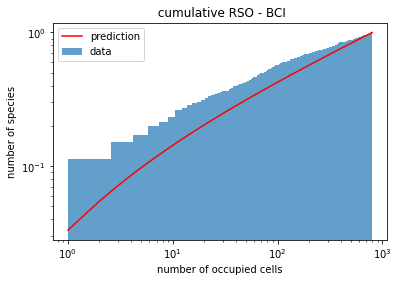

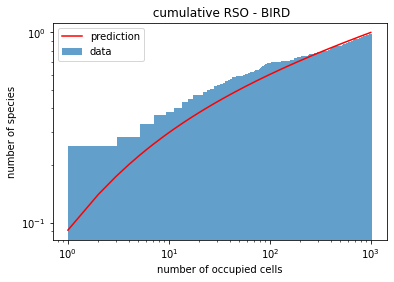

In [194]:
v1 = np.arange(1,800)
v2 = np.arange(1,1000)
cumBCI = np.cumsum(RSOapprox(v1,poptBCI01[0]))/np.max(np.cumsum(RSOapprox(v1,poptBCI01[0])))
cumBIRD = np.cumsum(RSOapprox(v2,poptBIRD01[0]))/np.max(np.cumsum(RSOapprox(v2,poptBIRD01[0])))

#BCI RSO
plt.hist(BCIpa.sum(axis=0),bins=500,cumulative=True,density=True,alpha=0.7,label='data')
plt.plot(v1,cumBCI,'r',label='prediction')
plt.xlabel('number of occupied cells')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('number of species')
plt.title(' cumulative RSO - BCI')
plt.legend()
plt.savefig('images/RSOBCI.png')
plt.show()

#BIRD RSO
plt.hist(BIRDpa.sum(axis=0),bins=500,cumulative=True,density=True,alpha=0.7,label='data')
plt.plot(v2,cumBIRD,'r',label='prediction')
plt.xlabel('number of occupied cells')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('number of species')
plt.title(' cumulative RSO - BIRD')
plt.legend()
plt.savefig('images/RSOBIRD.png')
plt.show()

## Infer at the real scale

The sampled area for the BCI forest is, in reality, 0.032

In [195]:
#BCI upscaling
p = 0.032
initial_data = BCIpa
tot_plot = initial_data.shape[0]
#print("Total number of subplots:",tot_plot)
tot_species = np.sum(initial_data,axis=0)
tot_species = len(tot_species[tot_species!=0])
poptBCI, perrBCI = fitSAR(empSAR_BCI,tot_plot,tot_species,plot=False)
csi_global_BCI = csi_global(poptBCI[1],p)
S_estimate_BCI = Sestimated(tot_species,poptBCI[1],poptBCI[0],p)
errS_estimate_BCI = errSestimated(poptBCI[1],poptBCI[0],p,tot_species,perrBCI)
print('S_est=',np.round(S_estimate_BCI),'errS_est',np.round(errS_estimate_BCI,1))

r_fit: 0.27502465759282835 std err: 0.0009560653881335847

csi_fit: 0.9987955960431387 std err: 8.697575738132653e-06
S_est= 337.0 errS_est 0.2


In [196]:
#BIRD upscaling

initial_data = BIRDpa
tot_plot = initial_data.shape[0]
tot_species = np.sum(initial_data,axis=0)
tot_species = len(tot_species[tot_species!=0])
poptBIRD, perrBIRD = fitSAR(empSAR_BIRD,tot_plot,tot_species,plot=False)
p = [0.05,0.2,0.44]

for j in range(len(p)):
    csi_global_BIRD = csi_global(poptBIRD[1],p[j])
    S_estimate_BIRD = Sestimated(tot_species,poptBIRD[1],poptBIRD[0],p[j])
    errS_estimate_BIRD = errSestimated(poptBIRD[1],poptBIRD[0],p[j],tot_species,perrBIRD)
    print(p[j],'S_est=',np.round(S_estimate_BIRD),'errS_est',np.round(errS_estimate_BIRD,1))

r_fit: 0.08570455858407153 std err: 0.0016028978660858075

csi_fit: 0.9991636648075592 std err: 1.652453265901562e-05
0.05 S_est= 313.0 errS_est 0.6
0.2 S_est= 284.0 errS_est 0.3
0.44 S_est= 266.0 errS_est 0.2


In [197]:
av_perc_err(224,2,246)

(-8.94308943089431, 0.8130081300813008)